In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

# LETSA
import matplotlib.dates as mdates
from datetime import datetime
import os
import time
import ast

# EDD
import heapq
import matplotlib.patches as mpatches

# SA
import matplotlib.patches as mpatches

# Class Definitions

In [14]:
class WorkCenter:
    def __init__(self, id, dict_machines={}):
        self.id = str(id)
        self.machines = dict_machines
        # dict_machines = {'M1': [ [], [], [] ] }

class Operation:
    def __init__(self, id, processing_time, workcenter, machine, due_date=None, successors=None, predecessors=None):
        self.id = str(id)
        self.successor = str(successors) if successors else None
        self.predecessors = predecessors if predecessors else []
        self.workcenter = str(workcenter)
        self.machine = str(machine)
        self.scheduled_machine_idx = None
        self.processing_time = processing_time
        self.start_time = None
        self.end_time = None
        self.due_date = None if due_date != due_date else due_date
        self.scheduled = False



# LETSA

In [56]:
def load_operations(df):
    """
    Loads the operation information from the df_BOM
    Initializes an Operation object for each of the operation and stores it in the operations dictionary
    Inputs: 
        - df            : a dataframe consisting the BOM information  
        - filename      : 
    Outputs:
        - operations    : 
    """

    operations = {}

    for index, row in df.iterrows():
        op = Operation(
            id=str(row['operation']),
            processing_time=row['processing_time'],
            workcenter=row['workcenter'],
            machine=row['machine'],
            due_date=row['due_date'],
            predecessors=row['predecessor_operations']
        )
        operations[op.id] = op

    for index, row in df.iterrows():
        current_op_id = row['operation']
        predecessor_ops = row['predecessor_operations']
        for predecessor in predecessor_ops:
            operations[predecessor].successor = current_op_id
    
    return operations

def load_factory(df_machine):
    factory = {}
    for idx, row in df_machine.iterrows():
        workcenter = row['workcenter']
        dict_machines = {}
        for machine in (df_machine.columns[1:]): 
            dict_machines[machine] = [[] for _ in range(row[machine])]
        # factory.append(WorkCenter(workcenter, dict_machines=dict_machines))
        factory[workcenter] = WorkCenter(workcenter, dict_machines=dict_machines)
    return factory 

def calculate_makespan(factory):
    list_schedules = []
    for workcenter_key in factory:
        for _, machine_schedule in factory[workcenter_key].machines.items():
            flattened_schedule = [item for sublist in machine_schedule for item in sublist]
            list_schedules += flattened_schedule

    _max = max(list_schedules, key=lambda x: x[1])[1]
    _min = min(list_schedules, key=lambda x: x[0])[0]

    for item in list_schedules: 
        print(item)

    return _max - _min

def format_schedule(scheduled_operations):
    df_schedule = pd.DataFrame()
    for i, operation in enumerate(scheduled_operations): 
        df_schedule.at[i, "Operation"] = operation.id
        df_schedule.at[i, "Start"] = operation.start_time
        df_schedule.at[i, "End"] = operation.start_time + operation.processing_time
        df_schedule.at[i, "WorkCenter"] = operation.workcenter
        df_schedule.at[i, "Machine"] = operation.machine
        df_schedule.at[i, "Machine Index"] = operation.scheduled_machine_idx+1

    df_schedule['PercentCompletion'] = 100  

    return df_schedule

In [42]:
def LETSA_find_critical_path(operations, feasible_operations): 
    """
    Finds the critical path among the feasible operations.
    Inputs:
        - operations                    : dictionary {operation_id: Operation()}, a dictionary of all operations
        - feasible_operations           : list[operation_id],  a list of operation IDs that are currently feasible
    Output:
        - critical_path, critical_length
    """

    def dfs(operations, current_op_id, path, path_length, all_paths):
        """ 
        Performs recursive DFS on the operation network. 
        Inputs: 
            - operations                : dictionary {operation_id: Operation()}, dictionary of all operations 
            - current_op_id             : str, the ID of the node at which the DFS is performed
            - path                      : list, to keep track of current path
            - path_length               : float, to keep track of current path length
            - all_paths                 : list, to keep track of all possible paths 
        Output: 
            - None, perform in place
        """

        path.append(current_op_id)
        path_length += operations[current_op_id].processing_time
        
        if not operations[current_op_id].predecessors:
            all_paths.append((list(path), path_length))
        else:
            for pred in operations[current_op_id].predecessors:
                dfs(operations, pred, path, path_length, all_paths)
        
        path.pop()
        path_length -= operations[current_op_id].processing_time

    def find_all_paths(operations, feasible_operations):
        """
        Calls DFS on all the feasible operations. 
        Inputs: 
            - operations                : dictionary {operation_id: Operation()}, dictionary of all operations 
            - feasible_operations       : list [operation_id], list of all feasible operations to perform DFS on 
        """

        all_paths = []
        for op_id in feasible_operations:
            dfs(operations, op_id, [], 0, all_paths)
        return all_paths

    all_paths = find_all_paths(operations, feasible_operations)
    # print("     printing all paths")
    # for path in all_paths: 
        # print(path[0], path[1])
    critical_path, critical_length = max(all_paths, key=lambda x:x[1])

    return critical_path, critical_length

def LETSA_schedule_operations(operations, factory):
    """
    Solves the assembly scheduling problem (ASP) using the Longest End Time Scheduling Algorithm (LETSA).
    Inputs:
        - operations            : dictionary {operation_id: Operation()}, a dictionary of all operations.
        - factory               : list [WorkCenter()], a list of WorkCenter objects, containing machine information and availability
    Output:
        - scheduled_operations  : list [Operation()], a list of Operation objects with start and end time schedules.
    """

    scheduled_operations = []
    # [[Step 4]]
    i = 1
    while True:
        # print(f"Iteration {i}")
        # ================================================================================================================
        #  [[4.0]] Feasible operations = every operation that is 
        #                               (1) not scheduled, and 
        #                               (2) has all successors scheduled, OR does not have any successors
        # ================================================================================================================
        feasible_operations = [op_id for op_id, op in operations.items() if ((not op.scheduled) and (op.successor==None or operations[op.successor].scheduled))]
        # print(f"feasible operations: {feasible_operations}")
        if not feasible_operations:
            break # terminate if all operations have been scheduled

        # ===================================================================
        #  [[4.1 - 4.3]] Compute critical path only for feasible operations
        # ===================================================================
        critical_path, length = LETSA_find_critical_path(operations, feasible_operations)
        selected_operation_id = critical_path[0]
        selected_operation = operations[selected_operation_id]
        # print(f"critical path: {critical_path}, length: {length}")
        # print(f"selected operation: {selected_operation_id}")

        # =====================================================================
        # [[4.4]] Set completion/end time of the selected operation as
        #         (ii) the start time of the successor, if a successor exists
        #         (ii) the project deadline, otherwise 
        # =====================================================================
        if selected_operation.successor: 
            # if the operation has a successor 
            # then the tentative end time is the start time of the successor
            successor_id = selected_operation.successor
            tentative_completion_time = operations[successor_id].start_time
        else: 
            # else, the operation is an end product and its tentative completion time must be its own deadline
            tentative_completion_time = selected_operation.due_date

        # ============================================================================
        #   [[4.5]] For each identical machine incuded in the required work-center 
        # ============================================================================
        def check_availability(time, machine_usage): 
            """
            Returns True if the time interval does not overlap with any intervals in machine_usage, False otherwise.
                time            : (start, end)
                machine_usage   : list of tuples [(start1, end1), (start2, end2), ...]
            """
            start, end = time
            for interval in machine_usage:
                interval_start, interval_end = interval
                if not (end <= interval_start or start >= interval_end):
                    return False
            return True

        def find_latest_start_time(completion_time, processing_time, machine_usage):
            """
            completion_time : float
            processing_time : float
            machine_usage   : list of tuples [(start1, end1), (start2, end2), ...]
            
            Returns the latest possible start time such that the job can be completed
            before the completion time and does not overlap with any intervals in machine_usage.
            """
            latest_start_time = completion_time - processing_time

            # Sort the machine usage intervals by their start times
            machine_usage = sorted(machine_usage, key=lambda x: x[0])
            
            # Iterate over the machine usage intervals in reverse order
            for interval in reversed(machine_usage):
                interval_start, interval_end = interval
                
                # Check if there is a gap between the intervals where the job can fit
                if interval_end <= latest_start_time:
                    if check_availability((latest_start_time, latest_start_time + processing_time), machine_usage):
                        return latest_start_time
                latest_start_time = min(latest_start_time, interval_start - processing_time)
            
            # Check if the latest possible start time is valid
            if check_availability((latest_start_time, latest_start_time + processing_time), machine_usage):
                return latest_start_time
            
            return None

        current_workcenter_id = str(selected_operation.workcenter)
        # print(type(current_workcenter_id))
        # print(factory)
        current_workcenter = factory[current_workcenter_id]             # WorkCenter object 
        machine_type = str(selected_operation.machine)                  # machine id of required machine
        possible_machines = current_workcenter.machines[machine_type]   # [[], [], []]

        processing_time = selected_operation.processing_time
        tentative_start_time = tentative_completion_time - processing_time
        possible_start_times = []
        for machine_idx, machine_schedule in enumerate(possible_machines):
            # print(machine_idx, machine_schedule)
            # if not machine_schedule:  # If machine schedule is empty, then machine is immediately useable
            #     latest_available_start_time = tentative_completion_time - selected_operation.processing_time
            if check_availability((tentative_start_time, tentative_completion_time), machine_schedule) :
                start_time, end_time = tentative_start_time, tentative_completion_time
            else: 
                start_time = find_latest_start_time(tentative_completion_time, processing_time, machine_schedule) 
                end_time = start_time + processing_time
            possible_start_times.append((machine_idx, start_time, end_time))
            # print(start_time, end_time)

        # ============================================================================
        #   [[4.6]] Select a machine to schedule operation Jc  
        # ============================================================================
        selected_machine, finalized_start_time, finalized_end_time = max(possible_start_times, key=lambda x:x[1]) 
        current_workcenter.machines[machine_type][machine_idx].append((finalized_start_time, finalized_end_time))

        # ============================================================================
        #   [[4.7]] Delete operation Jc from the network
        #   [[4.8]] Add all eligible operations into the list of feasible operations     
        # ============================================================================
        selected_operation.start_time = start_time
        selected_operation.end_time = end_time
        selected_operation.scheduled = True
        selected_operation.scheduled_machine_idx = selected_machine
        scheduled_operations.append(selected_operation)

        i += 1 
        # print()
        
    return scheduled_operations


# EDD

In [44]:
def EDD_find_earliest_start_time(machine_usage, minimum_start_time, processing_time, print_button=False):
    """
    Finds the earliest start time on the given machine that avoids overlapping with existing jobs.
    Inputs: 
        - machine_usage         : [(3,4), (5,6)] 
        - desired_start_time    : start time must not be earlier than this 
        - processing_time       : operation processing time 
    """
   
    machine_usage.sort()
    start_time = None

    if len(machine_usage) == 0:
        start_time = minimum_start_time 
        # if print_button:
        #     print("A")
        return start_time

    for i in range(len(machine_usage)-1): 
        # if print_button: 
        #     print("B")
        tentative_start = machine_usage[i][1]
        tentative_end = machine_usage[i+1][0]
        if (tentative_end - tentative_start >= processing_time) and (tentative_start >= minimum_start_time):
            start_time = tentative_start 
            return start_time 
    
    if start_time is None: 
        # if print_button: 
        #     print("C")
        #     print(machine_usage)
        start_time = machine_usage[len(machine_usage)-1][1]
        if start_time < minimum_start_time:
            start_time = minimum_start_time
        return start_time

def EDD_schedule_operations(operations, factory):
    def check_availability(start_time, processing_time, machine_usage):
        """
        Returns True if the time interval does not overlap with any intervals in machine_usage, False otherwise.
        """
        end_time = start_time + processing_time
        for interval in machine_usage:
            if len(interval) != 2:
                raise ValueError("Machine usage interval does not contain exactly 2 values")
            interval_start, interval_end = interval
            if not (end_time <= interval_start or start_time >= interval_end):
                return False
        return True

    # =====================
    #   Initialize Queue 
    # =====================
    scheduled_operations, Q = [], []
    unscheduled_dependencies = {op_id: len(op.predecessors) for op_id, op in operations.items()}
    # print(f"Unscheduled dependencies: {unscheduled_dependencies}")

    for op_id, count in unscheduled_dependencies.items():
        if count == 0:
            heapq.heappush(Q, (operations[op_id].due_date if operations[op_id].due_date is not None else float('inf'), 
                               operations[op_id].processing_time, op_id))

    i = 0
    while True:
        # ==================================
        #    POP OUT OPERATION USING EDD
        # ==================================
        i += 1
        if not Q: 
            break
        print_list = [item[2] for item in Q]
        print_list.sort()
        # print(f"Iteration {i}: {print_list}")
        _, _, operation_id = heapq.heappop(Q)
        operation = operations[operation_id]
        # print(f"{operation_id}")
        if operation.scheduled:
            continue

        # ==================================
        #        COMPUTE START TIME
        # ==================================
        # Compute (tentative) start time based on dependencies
        if operation.predecessors:
            predecessor_max_end_time = max(
                (operations[comp_id].end_time if operations[comp_id].end_time is not None else -float('inf'))
                for comp_id in operation.predecessors)
            minimum_start_time = predecessor_max_end_time
            # if operation.id == "J.6":
            #     print(operation.predecessors)
            #     print(predecessor_max_end_time)
        else:
            minimum_start_time = 0

        # Find the best machine and start time
        workcenter = factory[str(operation.workcenter)]
        machine_type = operation.machine
        best_start_time = float('inf')
        selected_machine = None

        # ==================================
        #           SELECT MACHINE
        # ==================================
        # Iterate through all functionally identical machine in the current workcenter
        # Find the best start time, which is the earliest possible start time
        list_machine_schedules = workcenter.machines[machine_type]
        if operation.id == "J.6":
            printer = True
        else:
            printer = False
        for machine_idx, machine_usage in enumerate(list_machine_schedules): 
            start_time = EDD_find_earliest_start_time(machine_usage, minimum_start_time, operation.processing_time, print_button=printer)
            if check_availability(start_time, operation.processing_time, machine_usage):
                if start_time < best_start_time:
                    # if operation.id == "J.6": 
                        # print(start_time)
                    best_start_time = start_time
                    selected_machine = machine_usage
                    selected_machine_idx = machine_idx 

        if selected_machine is None:
            # No available machine found; push operation back to recheck later
            heapq.heappush(Q, (operation.due_date if operation.due_date is not None else float('inf'), operation.processing_time, operation_id))
            # print(f"Operation {operation.id} not scheduled yet, re-adding to the queue")
            continue

        # ==================================
        #      SCHEDULE THE OPERATIONS
        # ==================================
        operation.start_time = best_start_time
        operation.end_time = operation.start_time + operation.processing_time
        operation.scheduled = True
        operation.scheduled_machine_idx = selected_machine_idx
        scheduled_operations.append(operation)
        # print(F"Selected {operation.id}")
        # print(f"Scheduled operations: {[op.id for op in scheduled_operations]}")
        # print("")
        workcenter.machines[machine_type][selected_machine_idx].append((operation.start_time, operation.end_time))

        # ==================================
        #           UPDATE QUEUE
        # ==================================
        # unscheduled_dependencies = {op_id: len(op.predecessors) for op_id, op in operations.items()}

        for op_id, op in operations.items(): 
            for comp_id in op.predecessors: 
                # print(f"my operation id: {operation.id}")
                # print(comp_id)
                if operation.id == comp_id: 
                    # print("yes")
                    # if the id of the previously scheduled operation is the same as the id of the iterated Op
                    # then we should reduce the unscheduled dependencies count by 1
                    unscheduled_dependencies[op_id] -= 1
                    # print(unscheduled_dependencies[op_id])
        # print(f"Unscheduled dependencies: {unscheduled_dependencies}")

        for op_id, count in unscheduled_dependencies.items():
            scheduled_operations_id = [scheduled_op.id for scheduled_op in scheduled_operations]
            list_Q = [queued_op[2] for queued_op in Q]
            if (count == 0) and (op_id not in scheduled_operations_id) and (op_id not in list_Q):
                heapq.heappush(Q, (operations[op_id].due_date if operations[op_id].due_date is not None else float('inf'), 
                                operations[op_id].processing_time, op_id))
                # print(f"Pushed {op_id} into Q")



        # for op_id, op in operations.items():
        #     if not op.scheduled and op_id in unscheduled_dependencies:
        #         # if the operation has not been scheduled, and is an unscheduled dependency
        #         # for each of the predecessors of this operation
        #         for comp_id in op.predecessors:
        #             if operations[comp_id].scheduled:
        #                 unscheduled_dependencies[op_id] -= 1
        #         if unscheduled_dependencies[op_id] == 0:
        #             heapq.heappush(Q, (op.due_date if op.due_date is not None else float('inf'), op.processing_time, op_id))
        #             # print(f"Operation {op_id} with no remaining dependencies added to the queue")

        # print("")
    return scheduled_operations





def plot_gantt_chart(factory, scheduled_operations):
    y_labels = []
    yticks = []
    y_pos = 0
    max_time = 0

    for wc_id, wc in factory.items():
        for machine_id, schedules in wc.machines.items():
            for idx, tasks in enumerate(schedules):
                y_label = f"{wc_id} - {machine_id} - #{idx+1}"
                y_labels.append(y_label)
                yticks.append(y_pos)

                for task in tasks:
                    start, end = task
                    max_time = max(max_time, end)
                    
                y_pos += 1

    fig_height = max(5, len(y_labels) * 0.6)
    fig, ax = plt.subplots(figsize=(fig_height*2, fig_height))

    for operation in scheduled_operations:
        start, end = operation.start_time, operation.end_time
        wc_id = operation.workcenter
        machine_id = operation.machine
        machine_idx = operation.scheduled_machine_idx

        y_label = f"{str(wc_id)} - {str(machine_id)} - #{int(machine_idx) + 1}"
        if y_label in y_labels:
            y_pos = y_labels.index(y_label)
            ax.add_patch(
                mpatches.Rectangle(
                    (start, y_pos - 0.4), end - start, 0.8,
                    edgecolor='black', facecolor='skyblue'
                )
            )
            ax.text(
                (start + end) / 2, y_pos, f'{operation.id}\n{start}-{end}',
                ha='center', va='center', color='black'
            )

    ax.set_yticks(yticks)
    ax.set_yticklabels(y_labels)
    ax.set_xlabel('Time')
    ax.set_ylabel('Workcenter - Machine - Index')
    ax.set_xlim(0, max_time)

    plt.show()


In [18]:
# import pandas as pd
# import networkx as nx
# import matplotlib.pyplot as plt

# # Your BOM DataFrame
# df_BOM = pd.DataFrame({
#     'operation': ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U'],
#     'predecessor_operations': [[], [], ["A"], ["B"], ["C", "D"], ["E", "G"], ["H"], [], ["F"], [], [], [], ["J", "K", "L"], ["M"], ["N"], [], [], ["P", "Q"], ["R"], ["S", "U"], []],
#     'end_product': [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0],
#     'due_date': [None, None, None, None, None, None, None, None, 50.0, None, None, None, None, None, 80.0, None, None, None, None, 30.0, None],
#     'processing_time': [3, 2, 1, 3, 1, 3, 5, 7, 4, 18, 12, 3, 5, 10, 4, 1, 8, 7, 5, 1, 8],
#     'workcenter': ['WC#2', 'WC#1', 'WC#1', 'WC#2', 'WC#2', 'WC#2', 'WC#2', 'WC#3', 'WC#2', 'WC#1', 'WC#2', 'WC#3', 'WC#2', 'WC#2', 'WC#3', 'WC#2', 'WC#1', 'WC#1', 'WC#2', 'WC#3', 'WC#1'],
#     'machine': ["M1", "M2", "M3", "M2", "M4", "M5", "M1", "M2", "M3", "M4", "M5", "M1", "M2", "M3", "M2", "M3", "M4", "M5", "M1", "M4", "M2"]
# })

# # Create a directed graph
# G = nx.DiGraph()

# # Add nodes and edges
# for i, row in df_BOM.iterrows():
#     G.add_node(row['operation'])
#     for pred in row['predecessor_operations']:
#         G.add_edge(pred, row['operation'])

# # Generate positions for nodes
# pos = nx.spring_layout(G)

# # Adjust positions to create a hierarchical layout
# levels = {}  # Dictionary to store levels of each node
# for node in nx.topological_sort(G):
#     if G.in_degree(node) == 0:
#         levels[node] = 0
#     else:
#         levels[node] = max(levels[pred] for pred in G.predecessors(node)) + 1

# # Adjust positions to reflect levels
# for node, level in levels.items():
#     pos[node][1] = -level

# # Draw the graph
# plt.figure(figsize=(12, 8))
# nx.draw(G, pos, with_labels=True, node_size=2000, node_color="lightblue", font_size=10, font_weight="bold", arrowsize=20)
# plt.title("BOM Network Visualization with Hierarchical Layout")
# plt.show()


# Test Cases

In [19]:
# df_BOM = pd.DataFrame({
#     'operation': ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U'],
#     'predecessor_operations': [[], [], ["A"], ["B"], ["C", "D"], ["E", "G"], ["H"], [], ["F"], [], [], [], ["J", "K", "L"], ["M"], ["N"], [], [], ["P", "Q"], ["R"], ["S", "U"], []],
#     'end_product': [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0],
#     'due_date': [None, None, None, None, None, None, None, None, 50.0, None, None, None, None, None, 80.0, None, None, None, None, 30.0, None],
#     'processing_time': [3, 2, 1, 3, 1, 3, 5, 7, 4, 18, 12, 3, 5, 10, 4, 1, 8, 7, 5, 1, 8],
#     'workcenter': ['WC#2', 'WC#1', 'WC#1', 'WC#2', 'WC#2', 'WC#2', 'WC#2', 'WC#3', 'WC#2', 'WC#1', 'WC#2', 'WC#3', 'WC#2', 'WC#2', 'WC#3', 'WC#2', 'WC#1', 'WC#1', 'WC#2', 'WC#3', 'WC#1'],
#     'machine': ["M1", "M2", "M3", "M2", "M4", "M5", "M1", "M2", "M3", "M4", "M5", "M1", "M2", "M3", "M2", "M3", "M4", "M5", "M1", "M4", "M2"]
# })
# display(df_BOM)
# df_machine = pd.DataFrame({
#     'workcenter': ["WC#1", "WC#2", "WC#3"],
#     'M1': [3, 2, 3],
#     'M2': [2, 1, 2],
#     'M3': [1, 2, 1],
#     'M4': [1, 1, 1],
#     'M5': [1, 2, 3]
# })
# # display(df_machine)
# factory = LETSA_load_factory(df_machine)
# operations = LETSA_load_operations(df_BOM)
# scheduled_operations = LETSA_schedule_operations(operations, factory)
# plot_gantt_chart(factory, scheduled_operations)
# print(calculate_makespan(factory))
# df_schedule = format_schedule(scheduled_operations)
# display(df_schedule)

# factory = load_factory(df_machine)
# operations = load_operations(df_BOM)
# scheduled_operations = EDD_schedule_operations(operations, factory)
# plot_gantt_chart(factory, scheduled_operations)
# print(calculate_makespan(factory))
# df_schedule = format_schedule(scheduled_operations)
# display(df_schedule)

In [20]:
# df_machine = pd.DataFrame({
#     'workcenter': ["WC#1", "WC#2", "WC#3"],
#     'M1': [1, 1, 1],
#     'M2': [2, 1, 1],
# })

# df_BOM = pd.read_csv("TestCases//30operations_2machines_0.15p_0.25D_(500,1000)dd.csv")
# df_BOM['predecessor_operations'] = df_BOM['predecessor_operations'].apply(lambda x: ast.literal_eval(x) if pd.notnull(x) else [])
# # display(df_BOM)

# # factory = load_factory(df_machine)
# # operations = load_operations(df_BOM)
# # scheduled_operations = LETSA_schedule_operations(operations, factory)
# # plot_gantt_chart(factory, scheduled_operations)
# # print(calculate_makespan(factory))
# # df_schedule = format_schedule(scheduled_operations)
# # display(df_schedule.sort_values(by='Operation'))

# factory = load_factory(df_machine)
# operations = load_operations(df_BOM)
# scheduled_operations = EDD_schedule_operations(operations, factory)
# # plot_gantt_chart(factory, scheduled_operations)
# print(calculate_makespan(factory))
# df_schedule = format_schedule(scheduled_operations)
# display(df_schedule)
# # display(df_schedule.sort_values(by='Operation'))



LETSA


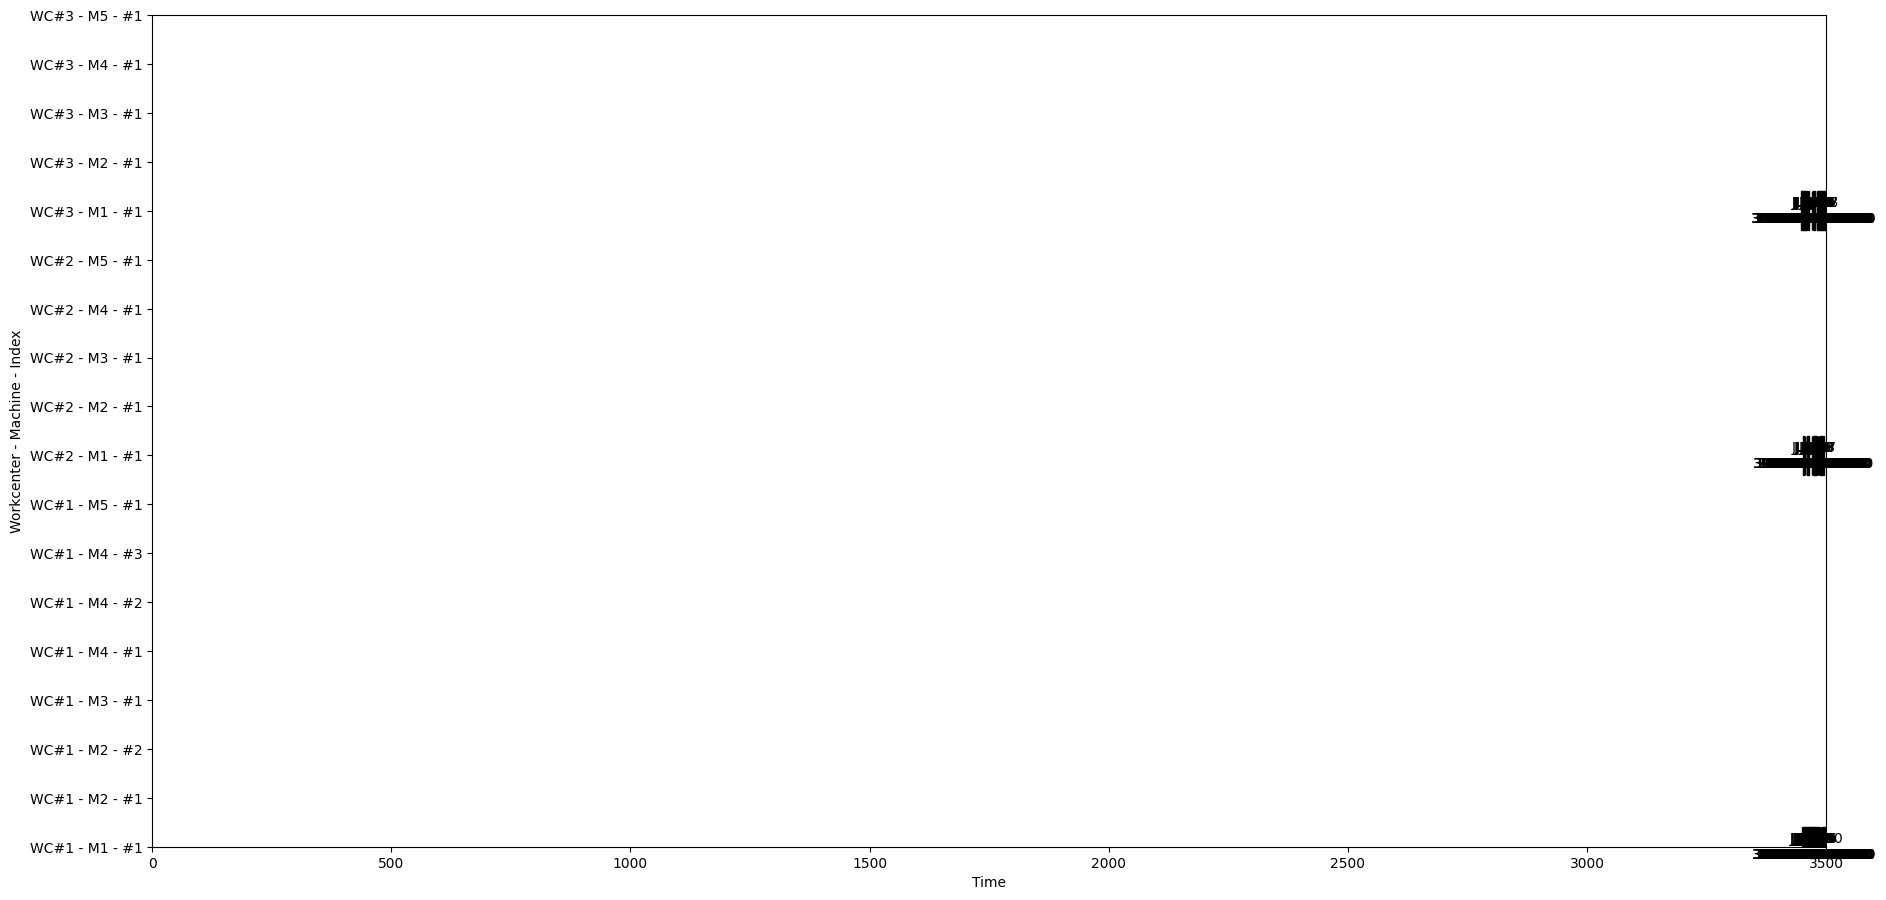

(3497.0, 3499.0)
(3495.0, 3496.0)
(3487.0, 3488.0)
(3486.0, 3487.0)
(3485.0, 3486.0)
(3481.0, 3482.0)
(3477.0, 3478.0)
(3476.0, 3477.0)
(3474.0, 3475.0)
(3473.0, 3474.0)
(3471.0, 3472.0)
(3469.0, 3470.0)
(3468.0, 3469.0)
(3467.0, 3468.0)
(3466.0, 3467.0)
(3465.0, 3466.0)
(3464.0, 3465.0)
(3461.0, 3462.0)
(3458.0, 3460.0)
(3457.0, 3458.0)
(3454.0, 3455.0)
(3496.0, 3497.0)
(3472.0, 3473.0)
(3492.0, 3493.0)
(3494.0, 3495.0)
(3462.0, 3464.0)
(3460.0, 3461.0)
(3470.0, 3471.0)
(3452.0, 3453.0)
(3456.0, 3457.0)
(3455.0, 3456.0)
(3478.0, 3480.0)
(3499.0, 3500.0)
(3453.0, 3454.0)
(3451.0, 3452.0)
(3450.0, 3451.0)
(3480.0, 3481.0)
(3475.0, 3476.0)
(3484.0, 3485.0)
(3489.0, 3490.0)
(3491.0, 3492.0)
(3493.0, 3494.0)
(3494.0, 3495.0)
(3491.0, 3492.0)
(3489.0, 3491.0)
(3484.0, 3485.0)
(3482.0, 3483.0)
(3480.0, 3481.0)
(3479.0, 3480.0)
(3478.0, 3479.0)
(3463.0, 3464.0)
(3460.0, 3461.0)
(3455.0, 3456.0)
(3477.0, 3478.0)
(3453.0, 3454.0)
(3475.0, 3477.0)
(3493.0, 3494.0)
(3459.0, 3460.0)
(3474.0, 3475.

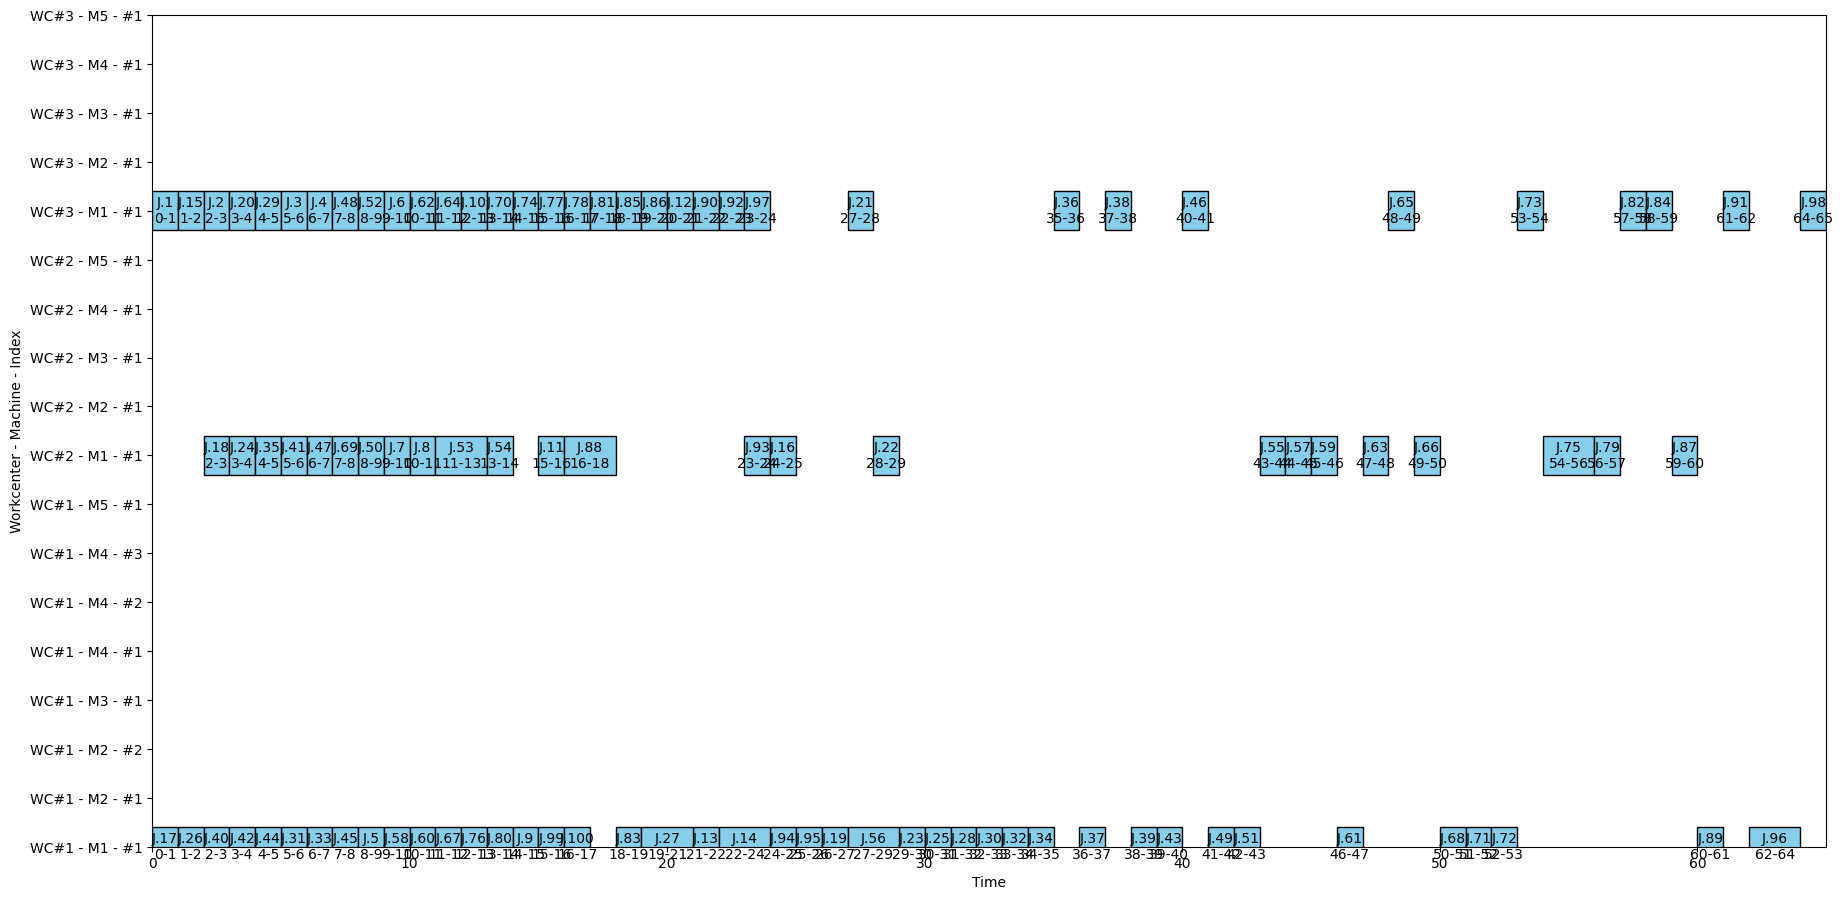

,Operation,Start,End,WorkCenter,Machine,Machine Index,PercentCompletion
0,J.1,0.0,1.0,WC#3,M1,1.0,100
1,J.15,1.0,2.0,WC#3,M1,1.0,100
2,J.17,0.0,1.0,WC#1,M1,1.0,100
3,J.18,2.0,3.0,WC#2,M1,1.0,100
4,J.2,2.0,3.0,WC#3,M1,1.0,100
...,...,...,...,...,...,...,...
95,J.88,16.0,18.0,WC#2,M1,1.0,100
96,J.89,60.0,61.0,WC#1,M1,1.0,100
97,J.91,61.0,62.0,WC#3,M1,1.0,100
98,J.96,62.0,64.0,WC#1,M1,1.0,100


In [61]:
df_machine = pd.DataFrame({
    'workcenter': ["WC#1", "WC#2", "WC#3"],
    'M1': [1, 1, 1],
    'M2': [2, 1, 1],
    'M3': [1, 1, 1],
    'M4': [3, 1, 1],
    'M5': [1, 1, 1],
})

# filename = "30operations_5machines_0.95p_0.75D_(500,750)dd.csv"
filename = "100operations_1machines_0.15p_0.75D_(1000,4000)dd.csv"
df_BOM = pd.read_csv(f"TestCases//{filename}")
df_BOM['predecessor_operations'] = df_BOM['predecessor_operations'].apply(lambda x: ast.literal_eval(x) if pd.notnull(x) else [])
# display(df_BOM)

# factory = load_factory(df_machine)
# operations = load_operations(df_BOM)
# scheduled_operations = LETSA_schedule_operations(operations, factory)
# plot_gantt_chart(factory, scheduled_operations)
# print(calculate_makespan(factory))
# df_schedule = format_schedule(scheduled_operations)
# display(df_schedule.sort_values(by='Operation'))

print("")
print("LETSA")
factory = load_factory(df_machine)
operations = load_operations(df_BOM)
scheduled_operations = LETSA_schedule_operations(operations, factory)
plot_gantt_chart(factory, scheduled_operations)
print(calculate_makespan(factory))
df_schedule = format_schedule(scheduled_operations)
# display(df_schedule)
# df_schedule.to_csv("debug2.csv")

factory = load_factory(df_machine)
operations = load_operations(df_BOM)
scheduled_operations = EDD_schedule_operations(operations, factory)
plot_gantt_chart(factory, scheduled_operations)
# print(calculate_makespan(factory))
df_schedule = format_schedule(scheduled_operations)
display(df_schedule)
# display(df_schedule.sort_values(by='Operation'))
# df_schedule.to_csv("debug1.csv")



# SA

In [22]:
# ==============
#       SA
# ==============
initial_temperature = 1000
cooling_rate = 0.8
min_temperature = 1
iterations_per_temp = 10

def SA_main(df_BOM, df_machine):
    # Create an initial schedule
    initial_schedule = SA_initial_solution(df_BOM)
    # print("Initial Schedule:", initial_schedule)

    # Test the revised evaluation function with machine availability
    initial_makespan, initial_usage = SA_calculate_makespan(initial_schedule, df_BOM, df_machine)
    # print("Initial Makespan with Machine Availability:", initial_makespan)

    # Run the simulated annealing algorithm
    best_schedule, best_makespan = simulated_annealing(df_BOM, df_machine, initial_schedule, initial_temperature, cooling_rate, min_temperature, iterations_per_temp)
    # print("Best Schedule:", best_schedule)
    # print("Best Makespan:", best_makespan)

    # Generate the Gantt chart for the best schedule
    # SA_generate_detailed_gantt_chart(best_schedule, df_BOM, best_makespan, df_machine)
    # SA_generate_beautified_gantt_chart(best_schedule, df_BOM, df_machine)

    # Export the best schedule to CSV
    return SA_format_schedule(best_schedule, df_BOM, df_machine)

def SA_initial_solution(df_BOM):
    schedule = []
    remaining_operations = set(df_BOM['operation'].tolist())
    
    while remaining_operations:
        for op in list(remaining_operations):
            predecessors = df_BOM[df_BOM['operation'] == op]['predecessor_operations'].values[0]
            if all(pred in schedule for pred in predecessors):
                schedule.append(op)
                remaining_operations.remove(op)
    
    return schedule

def SA_calculate_makespan(schedule, df_BOM, df_machine):
    end_times = {}
    machine_availability = {
        workcenter: {machine: [0] * df_machine.loc[df_machine['workcenter'] == workcenter, machine].values[0]
                     for machine in df_machine.columns if machine != 'workcenter'}
        for workcenter in df_machine['workcenter']
    }
    workcenter_machine_usage = {
        workcenter: {machine: [] for machine in df_machine.columns if machine != 'workcenter'}
        for workcenter in df_machine['workcenter']
    }

    for op in schedule:
        machine = df_BOM[df_BOM['operation'] == op]['machine'].values[0]
        workcenter = df_BOM[df_BOM['operation'] == op]['workcenter'].values[0]
        processing_time = df_BOM[df_BOM['operation'] == op]['processing_time'].values[0]
        predecessors = df_BOM[df_BOM['operation'] == op]['predecessor_operations'].values[0]

        # Calculate the earliest start time considering both predecessors and machine availability
        start_time = max([end_times.get(pred, 0) for pred in predecessors], default=0)
        
        # Find the earliest available machine in the workcenter
        earliest_machine_idx = min(range(len(machine_availability[workcenter][machine])), key=lambda x: machine_availability[workcenter][machine][x])
        start_time = max(start_time, machine_availability[workcenter][machine][earliest_machine_idx])

        # Calculate the end time of the operation
        end_time = start_time + processing_time
        end_times[op] = end_time

        # Update the machine availability and usage
        machine_availability[workcenter][machine][earliest_machine_idx] = end_time
        workcenter_machine_usage[workcenter][machine].append((start_time, end_time, op, earliest_machine_idx))

    return max(end_times.values()), workcenter_machine_usage

def SA_check_precedence_constraints(schedule, df_BOM):
    operation_positions = {op: idx for idx, op in enumerate(schedule)}
    for op in schedule:
        predecessors = df_BOM[df_BOM['operation'] == op]['predecessor_operations'].values[0]
        if any(operation_positions[pred] >= operation_positions[op] for pred in predecessors):
            return False
    return True

def SA_generate_neighbor(schedule, df_BOM):
    new_schedule = schedule[:]
    while True:
        idx1, idx2 = random.sample(range(len(schedule)), 2)
        new_schedule[idx1], new_schedule[idx2] = new_schedule[idx2], new_schedule[idx1]
        if SA_check_precedence_constraints(new_schedule, df_BOM):
            break
        else:
            new_schedule = schedule[:]
    return new_schedule

def SA_accept_solution(current_makespan, new_makespan, temperature):
    if new_makespan < current_makespan:
        return True
    else:
        prob = np.exp((current_makespan - new_makespan) / temperature)
        return random.random() < prob

def simulated_annealing(df_BOM, df_machine, initial_schedule, initial_temperature, cooling_rate, min_temperature, iterations_per_temp):
    current_schedule = initial_schedule
    current_makespan, _ = SA_calculate_makespan(current_schedule, df_BOM, df_machine)
    best_schedule = current_schedule
    best_makespan = current_makespan
    temperature = initial_temperature
    # print(temperature)
    while temperature > min_temperature:
        for _ in range(iterations_per_temp):
            new_schedule = SA_generate_neighbor(current_schedule, df_BOM)
            new_makespan, _ = SA_calculate_makespan(new_schedule, df_BOM, df_machine)
            
            if SA_check_precedence_constraints(new_schedule, df_BOM) and SA_accept_solution(current_makespan, new_makespan, temperature):
                current_schedule = new_schedule
                current_makespan = new_makespan
                
                if new_makespan < best_makespan:
                    best_schedule = new_schedule
                    best_makespan = new_makespan
        # print(temperature)
        temperature *= cooling_rate
    return best_schedule, best_makespan

def SA_generate_detailed_gantt_chart(schedule, df_BOM, total_makespan, df_machine):
    _, workcenter_machine_usage = SA_calculate_makespan(schedule, df_BOM, df_machine)

    # Generate colors for each machine-workcenter combination
    unique_machines = df_BOM['machine'].unique()
    unique_workcenters = df_BOM['workcenter'].unique()
    color_palette = plt.cm.get_cmap('tab20', len(unique_machines) * len(unique_workcenters))
    color_index = 0
    colors = {}
    for wc in unique_workcenters:
        for machine in unique_machines:
            colors[(wc, machine)] = color_palette(color_index)
            color_index += 1

    # Plot the Gantt chart
    fig, ax = plt.subplots(figsize=(15, 10))

    y_ticks = []
    y_labels = []
    y_position = 0

    for wc in df_machine['workcenter']:
        for machine in df_machine.columns:
            if machine != 'workcenter':
                num_machines = df_machine.loc[df_machine['workcenter'] == wc, machine].values[0]
                for machine_idx in range(num_machines):
                    if (wc in workcenter_machine_usage) and (machine in workcenter_machine_usage[wc]):
                        for (start, end, op, used_machine_idx) in workcenter_machine_usage[wc][machine]:
                            if used_machine_idx == machine_idx:
                                ax.broken_barh([(start, end - start)], (y_position - 0.4, 0.8), facecolors=(colors[(wc, machine)]))
                                ax.text(start, y_position, f" {op} ({machine}-{machine_idx + 1})", va='center', ha='left')

                    y_ticks.append(y_position)
                    y_labels.append(f"{wc} {machine}-{machine_idx + 1}")
                    y_position += 1

    ax.set_yticks(y_ticks)
    ax.set_yticklabels(y_labels)
    ax.set_xlabel('Time')
    ax.set_ylabel('Machine - Workcenter')
    ax.grid(True)

    # Ensure the x-axis matches the total makespan
    ax.set_xlim(0, total_makespan)

    # Create a legend for the color-coded machine and workcenter
    legend_patches = [mpatches.Patch(color=colors[(wc, machine)], label=f'{wc} - {machine}')
                      for wc in unique_workcenters for machine in unique_machines]
    ax.legend(handles=legend_patches, bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.show()

def SA_generate_beautified_gantt_chart(schedule, df_BOM, df_machine):
    schedule_data = []
    operation_end_times = {}
    machine_availability = {
        workcenter: {machine: [0] * df_machine.loc[df_machine['workcenter'] == workcenter, machine].values[0]
                     for machine in df_machine.columns if machine != 'workcenter'}
        for workcenter in df_machine['workcenter']
    }

    # Define a light color palette for each workcenter
    unique_workcenters = df_BOM['workcenter'].unique()
    color_palette = plt.cm.get_cmap('Pastel1', len(unique_workcenters))
    workcenter_colors = {workcenter: color_palette(i) for i, workcenter in enumerate(unique_workcenters)}

    for op in schedule:
        machine = df_BOM[df_BOM['operation'] == op]['machine'].values[0]
        workcenter = df_BOM[df_BOM['operation'] == op]['workcenter'].values[0]
        processing_time = df_BOM[df_BOM['operation'] == op]['processing_time'].values[0]
        predecessors = df_BOM[df_BOM['operation'] == op]['predecessor_operations'].values[0]

        # Calculate the earliest start time considering predecessors
        start_time = max([operation_end_times.get(pred, 0) for pred in predecessors], default=0)
        
        # Find the earliest available machine in the workcenter
        earliest_machine_idx = min(range(len(machine_availability[workcenter][machine])), key=lambda x: machine_availability[workcenter][machine][x])
        start_time = max(start_time, machine_availability[workcenter][machine][earliest_machine_idx])

        # Calculate the end time of the operation
        end_time = start_time + processing_time
        schedule_data.append({
            'Operation': op,
            'Start': start_time,
            'End': end_time,
            'Machine': machine,
            'Workcenter': workcenter,
            'Color': workcenter_colors[workcenter],
            'MachineIdx': earliest_machine_idx + 1
        })

        # Update the availability time for the machine in the workcenter
        machine_availability[workcenter][machine][earliest_machine_idx] = end_time
        operation_end_times[op] = end_time

    # Convert schedule data to DataFrame for plotting
    df_schedule = pd.DataFrame(schedule_data)

    # Plot the Gantt chart
    fig, ax = plt.subplots(figsize=(15, 10))

    for idx, row in df_schedule.iterrows():
        ax.broken_barh(
            [(row['Start'], row['End'] - row['Start'])],
            (idx - 0.4, 0.8),
            facecolors=(row['Color'])
        )
        ax.text(
            row['Start'] + 0.1,
            idx,
            f"{row['Operation']} ({row['Machine']}-{row['MachineIdx']})",
            va='center',
            ha='left',
            color='black'
        )

    ax.set_yticks(range(len(df_schedule)))
    ax.set_yticklabels(df_schedule['Operation'])
    ax.set_xlabel('Time')
    ax.set_ylabel('Operations')
    ax.grid(True)

    # Ensure the x-axis matches the total makespan
    ax.set_xlim(0, df_schedule['End'].max())

    plt.show()

def SA_format_schedule(schedule, df_BOM, df_machine):
    max_makespan, workcenter_machine_usage = SA_calculate_makespan(schedule, df_BOM, df_machine)
    export_data = []

    # Gather utilized machines information
    used_machines = set()
    for wc in workcenter_machine_usage:
        for machine in workcenter_machine_usage[wc]:
            for (start, end, op, machine_idx) in workcenter_machine_usage[wc][machine]:
                used_machines.add((wc, machine, machine_idx))
                export_data.append({
                    'Operation': op,
                    'Start': start,
                    'End': end,
                    'Workcenter': wc,
                    'Machine': machine,
                    'MachineIdx': machine_idx + 1
                })



    # Add unused machines information
    for wc in df_machine['workcenter']:
        for machine in df_machine.columns:
            if machine != 'workcenter':
                num_machines = df_machine.loc[df_machine['workcenter'] == wc, machine].values[0]
                for idx in range(num_machines):
                    if (wc, machine, idx) not in used_machines:
                        export_data.append({
                            'Operation': None,
                            'Start': None,
                            'End': None,
                            'Workcenter': wc,
                            'Machine': machine,
                            'MachineIdx': idx + 1
                        })
    
    return pd.DataFrame(export_data)



# Systematic Testing

In [23]:
import sys 
def print_progress_bar(iteration, total, length=50):
    if iteration == 0:
        return  # Don't print the progress bar when no progress has been made.
    percent = ("{0:.1f}").format(100 * (iteration / float(total)))
    filled_length = int(length * iteration // total)
    bar = '█' * filled_length + '-' * (length - filled_length)
    sys.stdout.write(f'\r|{bar}| {percent}% Complete')
    sys.stdout.flush()
    if iteration == total:
        print()

In [24]:
x = "hello"
print(x[:2])

he


In [31]:
# GENERATING THE FACTORY INFORMATION
random.seed(42)
n_workcenters, n_machines = 3, 5
dict_machine = {}
dict_machine[0] = pd.DataFrame({ 'workcenter': [f"WC{i}" for i in range(1,n_workcenters+1)] })
dict_machine[1] = pd.DataFrame({ 'workcenter': [f"WC{i}" for i in range(1,n_workcenters+1)] })
dict_machine[2] = pd.DataFrame({ 'workcenter': [f"WC{i}" for i in range(1,n_workcenters+1)] })

for machine_no in range(1,n_machines+1):
    dict_machine[0][f"M{machine_no}"] = [random.randint(1,5) for _ in range(1,n_workcenters+1)]
    dict_machine[1][f"M{machine_no}"] = [random.randint(1,3) for _ in range(1,n_workcenters+1)]
    dict_machine[2][f"M{machine_no}"] = [random.randint(1,1) for _ in range(1,n_workcenters+1)]


# files = os.listdir('TestCases') 
files = os.listdir('NewTest') 
files = [file for file in files if file[-3:] == "csv"]
total_files = len(files)
df_results = pd.DataFrame({
    'filename': [None],
    'LETSA_time_0': [None],
    'LETSA_time_1': [None],
    'LETSA_time_2': [None],
    'EDD_time_0': [None],
    'EDD_time_1': [None],
    'EDD_time_2': [None],
    'SA_time_0': [None],
    'SA_time_1': [None],
    'SA_time_2': [None],
    'LETSA_makespan_1': [None],
    'LETSA_makespan_2': [None],
    'LETSA_makespan_3': [None],
    'EDD_makespan_1': [None],
    'EDD_makespan_2': [None],
    'EDD_makespan_3': [None],
    'SA_makespan_1': [None],
    'SA_makespan_2': [None],    
    'SA_makespan_3': [None],    
})

folder_path = 'LETSA_testcase_1'
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

for i, filename in enumerate(files): 
    print(i)
    df_BOM = pd.read_csv(f"TestCases//{filename}")
    # print("df_BOM")
    # display(df_BOM)
    df_BOM['predecessor_operations'] = df_BOM['predecessor_operations'].apply(lambda x: ast.literal_eval(x) if pd.notnull(x) else [])
    # display(df_BOM)
    # print(type(df_BOM.at[i, "predecessor_operations"]))

    # LETSA
    LETSA_makespan, EDD_makespan, SA_makespan = [], [], []
    for j in range(3): 
        # print(j)
        df_machine = dict_machine[j]
        # display(df_machine)

        print("LETSA")
        start = time.time()
        factory = load_factory(df_machine)
        operations = load_operations(df_BOM)
        LETSA_scheduled_operations = LETSA_schedule_operations(operations, factory)
        end = time.time()
        LETSA_processing_time = end - start
        LETSA_makespan.append(calculate_makespan(factory))
        print(LETSA_processing_time)

        # EDD
        print("EDD")
        start = time.time()
        factory = load_factory(df_machine)
        operations = load_operations(df_BOM)
        EDD_scheduled_operations = EDD_schedule_operations(operations, factory)
        end = time.time()
        EDD_processing_time = end - start
        EDD_makespan.append(calculate_makespan(factory))
        print(EDD_processing_time)

        # SA
        print("SA")
        start = time.time()
        SA_scheduled_operations = SA_main(df_BOM, df_machine)
        end = time.time()
        SA_processing_time = end - start 
        print(SA_processing_time)

        df_results.at[i, f"LETSA_time_{j}"] = LETSA_processing_time
        df_results.at[i, f"EDD_time_{j}"] = EDD_processing_time
        df_results.at[i, f"SA_time_{j}"] = SA_processing_time

    df_results.at[i, 'LETSA_makespan_1'] = LETSA_makespan[0]
    df_results.at[i, 'LETSA_makespan_2'] = LETSA_makespan[1]
    df_results.at[i, 'LETSA_makespan_3'] = LETSA_makespan[2]
    df_results.at[i, 'EDD_makespan_1'] = EDD_makespan[0]
    df_results.at[i, 'EDD_makespan_2'] = EDD_makespan[1]
    df_results.at[i, 'EDD_makespan_3'] = EDD_makespan[2]

    df_results.at[i, "filename"] = filename



0
LETSA
0.003999233245849609
EDD
0.028708457946777344
SA
32.00137686729431
LETSA
0.0050048828125
EDD
0.014711141586303711
SA
30.716190814971924
LETSA
0.0037360191345214844
EDD
0.020014286041259766
SA
29.61532473564148
1
LETSA
0.00618743896484375
EDD
0.016750812530517578
SA
30.8038330078125
LETSA
0.00424957275390625
EDD
0.012722253799438477
SA
30.620596170425415
LETSA
0.006663799285888672
EDD
0.02041029930114746
SA
30.389615774154663
2
LETSA
0.001638650894165039
EDD
0.01772022247314453
SA
54.15668773651123
LETSA
0.003049612045288086
EDD
0.02040553092956543
SA
57.679993629455566
LETSA
0.005093097686767578
EDD
0.018741846084594727
SA
53.78616976737976
3
LETSA
0.0066165924072265625
EDD
0.015122652053833008
SA
33.42967867851257
LETSA
0.006898403167724609
EDD
0.01801156997680664
SA
32.99017095565796
LETSA
0.005041837692260742
EDD
0.019722700119018555
SA
34.59537434577942
4
LETSA
0.013241291046142578
EDD
0.016653060913085938
SA
29.8502299785614
LETSA
0.009819984436035156
EDD
0.016712188720703

In [32]:
# df_results.to_csv("debug_results.csv")